# Exercise Sheet No. 11

---

> Machine Learning for Natural Sciences, Summer 2023, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 11.07.2023, 8 am
>
>Container version 1.0.2
> 
> Tutor: luca.torresi@kit.edu  
> **Please ask questions in the forum and only contact the Tutor when there are issues with the grading**

---
**Topic**: This exercise sheet will introduce you to generative models in machine learning.

# Variational AutoEncoders

In this exercise we will work on Variational AutoEncoders, first introduced by Welling and Kingma in a popular paper published in 2014 (https://arxiv.org/pdf/1312.6114.pdf).
We will implement a vanilla version of VAE, with encoder and decoder composed of fully connected layers only, and try to use it for an anomaly detection task. We will then see how we can impose nice properties on the latent representation of data produced by the network simply augmenting it with a linear regressor.

In [1]:
import os
import zipfile
%matplotlib notebook
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter

from typing import Optional
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from Utils import get_data, AbstractTrainer, plot_reconstr

Let's take a look at the data we will work on.

The dataset consists of ECG segments of healthy patients and patients suffering from premature ventricular contraction (PVC). Segments were padded or cut to measure 350 time steps each.

In the first part of the exercise we will implement a detector for anomalous hearbeats, thus our training and validation sets will consist of normal heartbeats only while in the test set we will have both normal and PVC ECGs.

In [25]:
if not os.path.exists('ECG.h5'):
    with zipfile.ZipFile('ECG.zip', 'r') as zip:
        zip.extractall()

np.random.seed(101)
train, val, test = get_data(batch_size=1)
print(f'Dimension of \n\t train set : {len(train)} data points \n\t validation set : {len(val)} data points \n\t test set : {len(test)} data points')
counts = Counter()
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True)
for batch in test:
    if sum(counts.values())==6:
            break
    data = batch['data']
    label = batch['labels']
    if label==0 and counts[0]<3:
        axs[0, counts[0]].plot(np.arange(350), data.squeeze())
        counts[0] += 1
    if label==1 and counts[1]<3:
        axs[1, counts[1]].plot(np.arange(350), data.squeeze())
        counts[1] += 1
axs[0,0].set_ylabel('Normal')
axs[1,0].set_ylabel('PVC')
fig.tight_layout()
fig.show()

Dimension of 
	 train set : 6585 data points 
	 validation set : 997 data points 
	 test set : 1275 data points


/tmp/ipykernel_55/3841966391.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True)


<IPython.core.display.Javascript object>

An autoencoder is an unsupervised representation learning algorithm based on neural networks that is used to learn efficient codings of unlabeled data. In particular, by imposing a bottleneck in the encoding layer of the network we can extract a compressed representation of the original input leveraging the structure present in it, i.e. the correlations among input features. 

In an AE input data is converted into a deterministic encoding vector, i.e. for each of the latent features the encoder outputs a single value. VAEs are an extension of AE int the sense that instead of performing a single value estimation of the latent vector they produce a probabilistic distribution $q_{\phi}(z|x)$ in the latent space. This is done leveraging variational bayesian inference: an approximation of the distribution is picked from some tractable family and then this is made as close as possible to the true posterior. In particular in the original formulation of VAE the prior imposed on the latent representation is a standard Gaussian and the mean field approximation is used, i.e. the latent variables are considered as independent from each other.

Being the latent representation of our data a probabilistic distribution, to reconstruct input data we have to sample points from it $z$~$q_{\phi}(z|x)$. The fact that one of the nodes in the computational graph is a random node would create a problem in the backpropagation step because the gradient would not be able to 'flow' through it.

One of the key elements in the VAE architecture is the so called 'reparameterization trick', that allow us to express a distribution $q_{\phi}(z|x)$ as a two-step generative process:
1. sample a noise variable $\epsilon$ from a simple distribution:
2. apply a deterministic transformation $g_{\phi}(\epsilon,x)$ that maps the random noise into a more complex distribution.


In the case of Gaussian distributions the reparametrization trick is particularly simple: instead of writing $z$∼$q_{\phi}(z|x)=\mathcal{N}(\mu_{\phi}, \Sigma_{\phi})$ we can just write $z=g_{\phi}(\epsilon, x)= \mu_{\phi} +  \sigma_{\phi}*\epsilon$,  where $\epsilon$ is a vector of iid variables $\epsilon_{i}$∼$\mathcal{N}(0,1)$ and $*$ is the Hadamard product, and then backpropagate the gradient through $\mu_{\phi}$ and $\sigma_{\phi}$, as shown in the following picture:


<br>

<img src="reparam.png" style="width: 500px;">

In the following a partial implementation of a simple VAE with MLPs as encoder and decoder is provided. Complete the functions, paying attention to the fact that the encoder has to produce the logarithm of the standard deviation of each of the latent variables (this is done to ensure that the standard deviation is always positive).

Hint: torch has a function similar to numpy.random.randn

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim : int = 350, embedding_dim : int = 30):
        super().__init__()
        self.embedding_dim = embedding_dim

        self._backbone = nn.Sequential(nn.Linear(input_dim, 500),
                    nn.LeakyReLU(negative_slope=0.2),
                    nn.Dropout(0.4)
                    )
        self._fc_mean = nn.Linear(500, embedding_dim)
        self._fc_logstd = nn.Sequential(nn.Linear(500, embedding_dim),
                                    nn.LeakyReLU(negative_slope=0.05)
                                   )
        
        self._decoder = nn.Sequential(nn.Linear(embedding_dim, 500),
                    nn.LeakyReLU(negative_slope=0.2),
                    nn.Dropout(0.4),
                    nn.Linear(500, input_dim)
                    )

    def encode(self, x):
        '''
        The encoder is composed of a first fully connected layer followed by 
        two parallel linear layers that generate independently the mean and logstd of the latent distribution
        '''
        temp = None
        mean, logstd = None, None
        temp = self._backbone(x)
        mean = self._fc_mean(temp)
        logstd = self._fc_logstd(temp)
        #raise NotImplementedError()
        return mean, logstd
        
    def reparameterize(self, mean, logstd): 
        '''
        Once the latent distribution is computed from the input a latent vector has to be sampled from it.
        We are working on gaussians, look at the formula in the block above 
        and remember that the encoder produces the logstd.
        '''
        std = None
        eps = None
        z = None
        std  = torch.exp(logstd)
        eps = torch.randn_like(std)
        z = mean + eps*std
        #raise NotImplementedError()
        return z
    
    def decode(self, z):
        return self._decoder(z)

    def forward(self, x):
        '''
        VAE computes the latent distribution associated with the input, 
        samples a vector from it and finally decodes it.
        '''
        mean, logstd = None, None
        z = None
        out = None 
        mean, logstd = self.encode(x)
        z = self.reparameterize(mean, logstd)
        out = self.decode(z)
        #raise NotImplementedError()
        return [out, mean, logstd, z]
    

In [4]:
# encode - 2 point

vae = VAE(1,2)
m, s = vae.encode(torch.Tensor([1]))
assert m.shape==s.shape and m.shape==torch.Size([2]), 'error in encodings dimension'

# other hidden tests

In [5]:
# reparametrize - 1 point
vae = VAE(1,2)
s = vae.reparameterize(torch.Tensor([0,0]), torch.log(torch.tensor([1,1])))
assert s.size()==torch.Size([2]), 'error in dimension of generated random vector'

# hidden MonteCarlo test to check that reparameterize(m, s) produces samples from a normal distribution N(m,s)

In [6]:
# forward - 1 point
in_dim, emb_dim = torch.randint(1, 10, (2,))
vae = VAE(in_dim, emb_dim)
inp = torch.randn(in_dim)
out, _, _, z = vae.forward(inp)
print(f'input and output have same dimension: {inp.shape==out.shape}')
print(f'latent vector is {emb_dim}-dimensional: {z.shape==torch.Size([emb_dim])}')

# similar hidden tests...

input and output have same dimension: True
latent vector is 7-dimensional: True


What we want to maximize in variational Bayes methods is the ELBO, which stands for "evidence lower bound":

$
\begin{align}
ELBO(\theta, \phi) = [\mathbb{E}_{q_{\phi}(z)}[\log p_{\theta}(x, z) - \log q_{\phi}(z|x)] ] = \\
-KL[q_{\phi}(z|x)|| p_{\theta}(z)] + \frac{1}{L} \sum_{l=1}^{L} \log p_{\theta}(x|z^{(l)})
\end{align}
$

where $q_{\phi}(z|x)$ represents the encoder and $\log p_{\theta}(x|z^{(l)})$ is the loglikelihood of the reconstruction and depends on the decoder parameters. (Loglikelihood is a fancy term which in our case represent simply the reconstruction error. Take a look at Bayesian interpretations of loss functions (MSE is the easiest) if you are interested)

The KL (Kullback–Leibler) divergence is a measure of how similar two probability distributions are (if equal -> KL=0) and it is also known as relative entropy. Note that the KL divergence is not a distance metric since it is not symmetric.

The KL divergence of some families of distributions can be computed analytically and that's the case if we choose Gaussians priors and posteriors.

Implement the KL divergence between a Gaussian posterior $q_{\phi}(z|x) = \mathcal{N}(\mu, \Sigma)$, where $\Sigma = diag(\sigma_{j})$ with $j \in {1, ..., J}$, and a standard Gaussian prior $p(z) = \mathcal{N}(0, I)$ : &emsp; $-\frac{1}{2} \sum_{j=1}^{J} (1 + \log((\sigma_{j})^{2}) - (\mu_{j})^{2} - (\sigma_{j})^2)$

<br><br><br>

<img src="vae.png" style="width: 500px;">





In [7]:

def KL_normnorm(mean, logstd):
    '''
    Implement the closed form of KL divergence for a gaussian N(mean, std) as posterior 
    and a standard gaussian N(0, 1) as prior. Careful with the logarithm!
    '''
    kl = None
    kl = -0.5 * torch.sum(1 + 2 * logstd - mean**2 - torch.exp(2 * logstd))
    return kl

In [8]:
# kl_divergence - 3 point
mean = torch.randn(3)
logstd = abs(torch.randn_like(mean))
try:
    KL_normnorm(mean, logstd).item()
except:
    print('KL divergence of two probability distributions is a number, not a vector...')

# hidden test that checks the KL_normnorm gives correct values

Differently from the original formulation of VAE we are going to multiply the KL divergence with a scalar parameter in such a way to regulate the tradeoff between the two terms of the ELBO loss (this is somehow similar to beta-VAE: https://openreview.net/references/pdf?id=Sy2fzU9gl). Then, as suggested in https://arxiv.org/pdf/1511.06349.pdf, we will initially set this parameter to zero and increase it linearly w.r.t. the number of epochs (this approach is termed KL warmup).

In [9]:
class VAE_Trainer(AbstractTrainer):
    def __init__(self, model : nn.Module, 
                 train_loader : Optional[DataLoader] = None, 
                 val_loader : Optional[DataLoader] = None,
                 test_loader : Optional[DataLoader] = None, 
                 optimizer = None):
        super().__init__(model=model,
                         train_loader = train_loader, 
                         val_loader = val_loader, 
                         test_loader = test_loader, 
                         optimizer = optimizer,
                         kl_scaling = 0.1)
        self.measures = {'elbo' : [], 'reconstr' : [], 'kl': []}

    def _loss(self, target, label, *args):
        out = args[0] 
        mean = args[1]
        logstd = args[2]
        batch_dim = target.shape[0]
        # loglikelihood
        reconstr_error = self.reconstr_loss(out, target).sum()/batch_dim
        # KL divergence
        kl = KL_normnorm(mean, logstd)/batch_dim
        # combine loglikelihood and KL divergence in the ELBO loss
        ELBO = reconstr_error + kl * self.kl_scaling * (self.ep/self.epochs) # kl * scaling * warmup_term
        return [ELBO, reconstr_error, kl]

    def test(self):
        self.model.eval()
        reconstr_errors = []
        with torch.no_grad():
            for batch in self.train_loader:
                data = batch['data'].to(self.device)
                out, mean, logstd, z = self.model(data)
                reconstr_error = self.reconstr_loss(out, data).sum(-1)
                reconstr_errors.append(reconstr_error)
        reconstr_errors = torch.cat(reconstr_errors)
        # set the threshold on the 0.85 quantile of the reconstruction error on the train set (normal behaviour)
        thresh = torch.quantile(reconstr_errors, 0.85)
        print(f'reconstr_errors avg : {reconstr_errors.mean()}, thresh : {thresh}')
        fig, ax = plt.subplots()
        ax.hist(reconstr_errors.numpy(), bins=np.arange(0, 15, 0.125))
        ax.set_title('train')
        ax.axvline(x=thresh, c='red')
        fig.show()

        reconstr_errors = []
        labels = []
        with torch.no_grad():
            for batch in self.test_loader:
                data = batch['data'].to(self.device)
                label = batch['labels'].to(self.device).squeeze()
                out, mean, logstd, z = self.model(data)
                reconstr_error = self.reconstr_loss(out, data).sum(-1)
                reconstr_errors.append(reconstr_error)
                labels.append(label)
        reconstr_errors = torch.cat(reconstr_errors)
        labels = torch.cat(labels)

        outliers_error = reconstr_errors[labels==1]
        normal_error = reconstr_errors[labels==0]
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
        ax1.hist(normal_error.numpy(), bins=np.arange(0, 15, 0.125))
        ax1.set_title('normal')
        ax1.axvline(x=thresh, c='red')
        ax2.hist(outliers_error.numpy(), bins=np.arange(0, 15, 0.125))
        ax2.set_title('anomalies')
        ax2.axvline(x=thresh, c='red')
        fig.show()
        print(f' avg recontruction error \n \t normal data : {normal_error.mean()}, anomalies : {outliers_error.mean()}')
        
        fig, ax = plt.subplots()
        preds = (reconstr_errors>thresh).float()
        cm = confusion_matrix(labels.numpy(), preds.numpy(), normalize='true')
        sb.heatmap(cm, square=True, xticklabels=False, yticklabels=False, 
                    annot=True, cbar=False, cmap="Reds", fmt='.2f').get_figure()
        ax.set_title('Anomaly detection: confusion matrix')
        fig.show()
        
        ##compute precision, recall and f1-score
        # precision = true_positive/(true_positive + false_positive)
        # recall = true_positive/(true_positive + false_negative)
        true = labels==1            
        tp = preds[true].sum()      # true_positive
        pos = (preds==1).sum()      # (true_positive + false_positive)
        true = true.sum()           # (true_positive + false_negative)
        
        precision = tp/pos
        recall = tp/true
        F1_score = 2*(precision * recall)/(precision + recall)
        
        print(f'Quality measures of our classifier:\n\t precision : {precision}\n\t recall : {recall}\n\t F1_score : {F1_score}')


We will now train our network on the 'normal' ECGs for a cycle of 100 epochs, without using any early stopping criteria, with a scaling constant of 0.1 for the KL divergence and using KL warmup. We will then use our VAE as anomaly detector on a test set composed of an equal (more or less) number of 'normal' and 'PVC' ECGs. 

To do so we will compute the distribution of the reconstruction errors over the training set, we will get the 0.85 (arbitrarily) quantile of the distribution and use it as a threshold to classify unseen data as belonging or not to the 'normal' class. 

Graphs produced are:
1. summary of training
2. few examples of reconstruction of test data
3. distribution of reconstruction errors on training set and 0.85 quantile in red
4. distribution of reconstruction errors on test set, separately for the 2 classes (threshold in red)
5. confusion matrix associated to our detector

Three measures were computed to evaluate our classifier: precision, recall and F1 score. Check the code above to see how these are computed.


===> epoch: 0
Train	elbo : 45.491066 reconstr : 45.491066 kl : 3.06658 
Val	elbo : 12.97062 reconstr : 12.97062 kl : 13.377663 

===> epoch: 1
Train	elbo : 16.221468 reconstr : 16.203436 kl : 18.032791 
Val	elbo : 8.677872 reconstr : 8.659162 kl : 18.710334 

===> epoch: 2
Train	elbo : 10.588889 reconstr : 10.539303 kl : 24.792892 
Val	elbo : 7.460286 reconstr : 7.40499 kl : 27.648015 

===> epoch: 3
Train	elbo : 8.136293 reconstr : 8.027653 kl : 36.213444 
Val	elbo : 6.477177 reconstr : 6.365173 kl : 37.334723 

===> epoch: 4
Train	elbo : 7.147893 reconstr : 6.979009 kl : 42.22104 
Val	elbo : 6.099486 reconstr : 5.941885 kl : 39.400182 

===> epoch: 5
Train	elbo : 6.476189 reconstr : 6.261262 kl : 42.98537 
Val	elbo : 5.625248 reconstr : 5.425608 kl : 39.927996 

===> epoch: 6
Train	elbo : 6.179451 reconstr : 5.916706 kl : 43.790958 
Val	elbo : 5.47656 reconstr : 5.243089 kl : 38.911722 

===> epoch: 7
Train	elbo : 6.017101 reconstr : 5.718824 kl : 42.611043 
Val	elbo : 5.359226 reco

Train	elbo : 4.564726 reconstr : 3.615529 kl : 14.831205 
Val	elbo : 3.880444 reconstr : 2.971873 kl : 14.196424 

===> epoch: 65
Train	elbo : 4.542606 reconstr : 3.586751 kl : 14.705457 
Val	elbo : 3.88796 reconstr : 2.97706 kl : 14.013844 

===> epoch: 66
Train	elbo : 4.54802 reconstr : 3.594562 kl : 14.446335 
Val	elbo : 3.928425 reconstr : 3.011587 kl : 13.891483 

===> epoch: 67
Train	elbo : 4.548251 reconstr : 3.575236 kl : 14.522599 
Val	elbo : 3.900683 reconstr : 2.974028 kl : 13.830666 

===> epoch: 68
Train	elbo : 4.582236 reconstr : 3.60877 kl : 14.315677 
Val	elbo : 3.918331 reconstr : 2.983502 kl : 13.747488 

===> epoch: 69
Train	elbo : 4.607547 reconstr : 3.621895 kl : 14.284814 
Val	elbo : 3.939848 reconstr : 2.995141 kl : 13.691416 

===> epoch: 70
Train	elbo : 4.587169 reconstr : 3.592304 kl : 14.212355 
Val	elbo : 3.917973 reconstr : 2.965753 kl : 13.603143 

===> epoch: 71
Train	elbo : 4.555184 reconstr : 3.551204 kl : 14.140565 
Val	elbo : 3.92757 reconstr : 2.9667

<IPython.core.display.Javascript object>


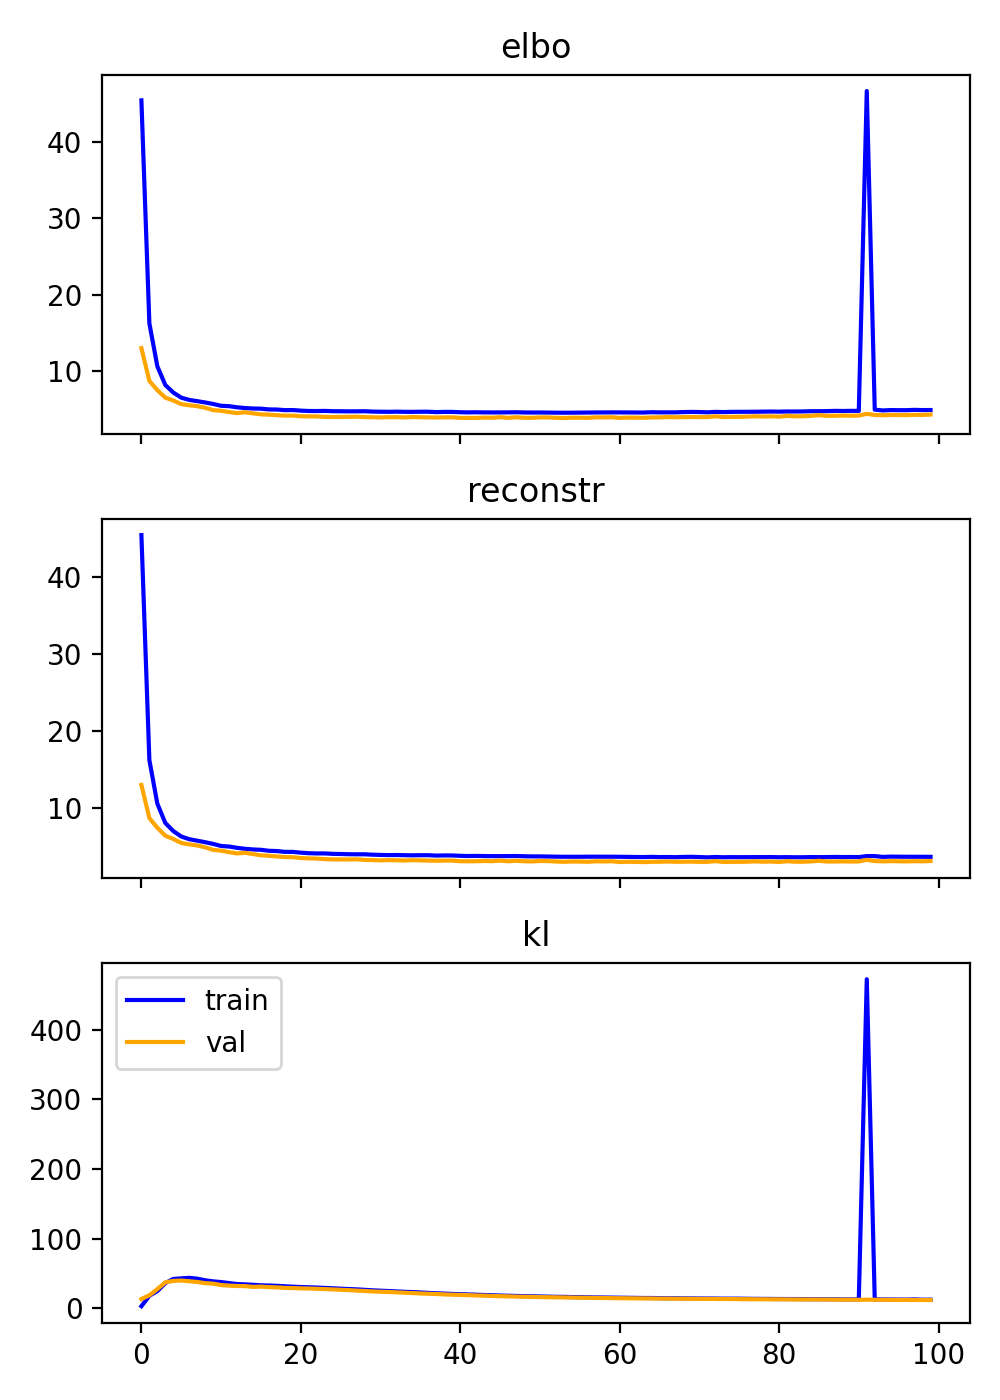

Let's plot some reconstructed data: 


<IPython.core.display.Javascript object>


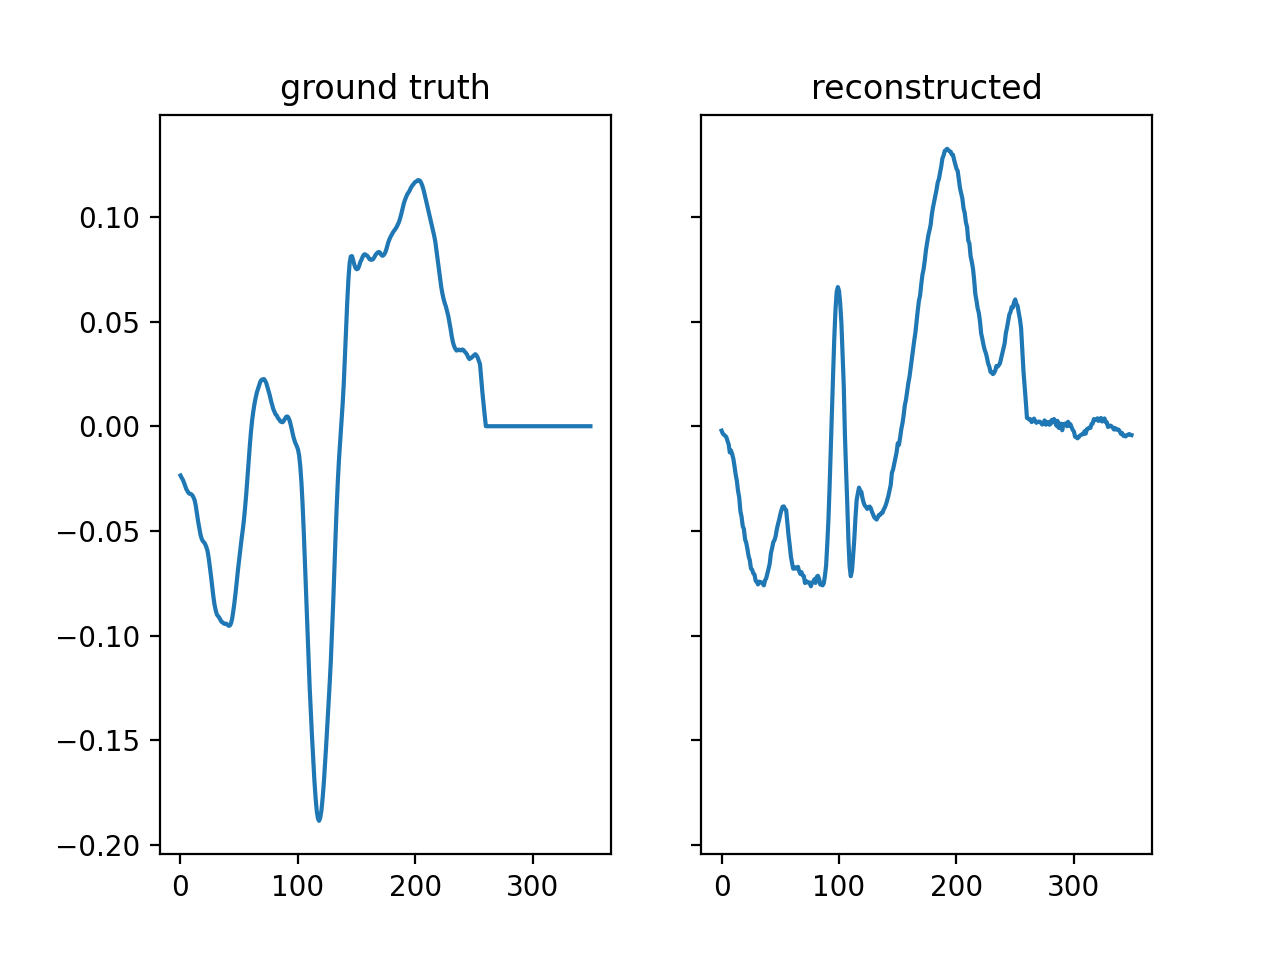

<IPython.core.display.Javascript object>


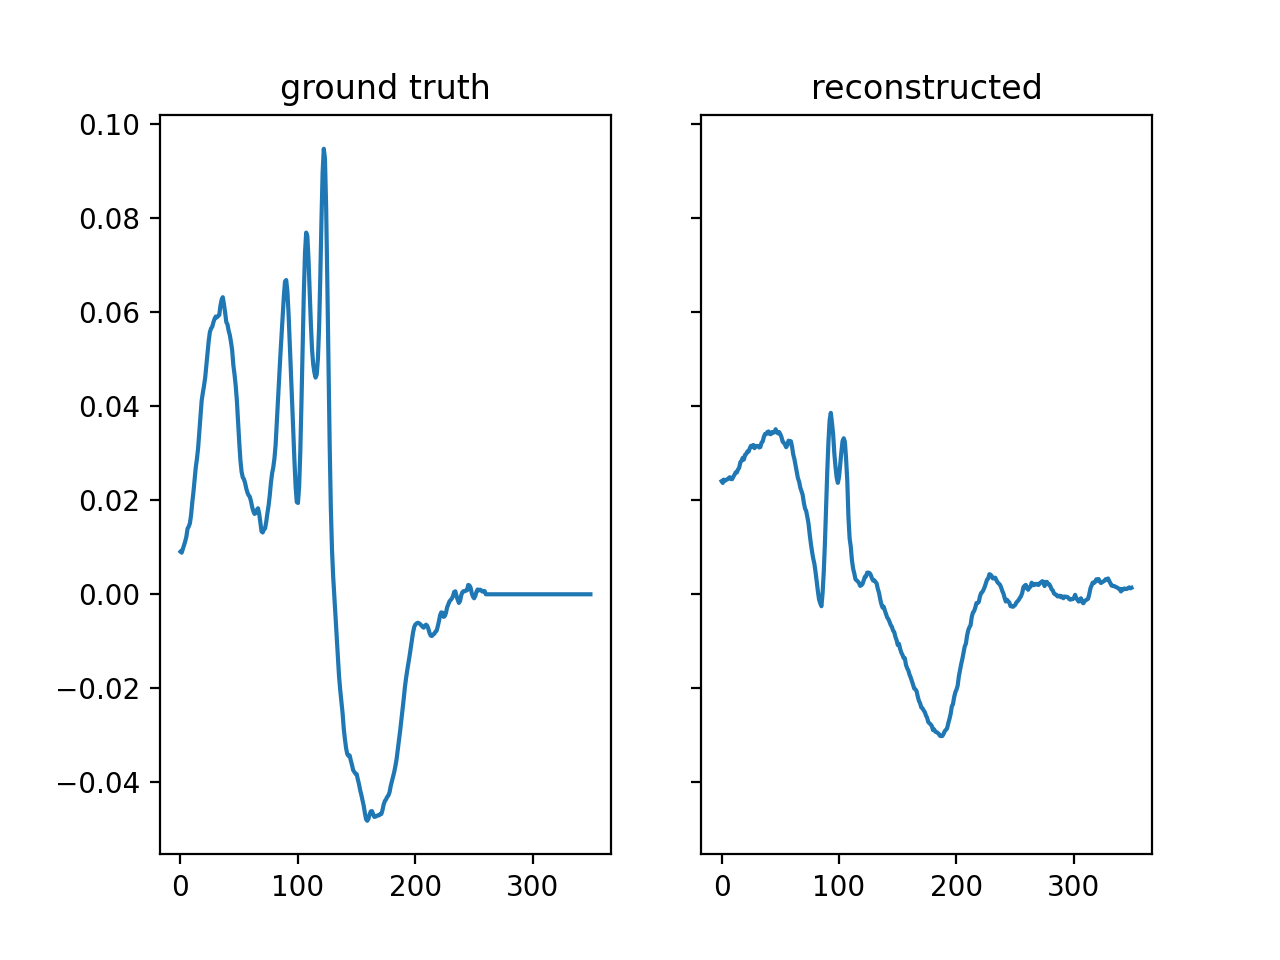

<IPython.core.display.Javascript object>


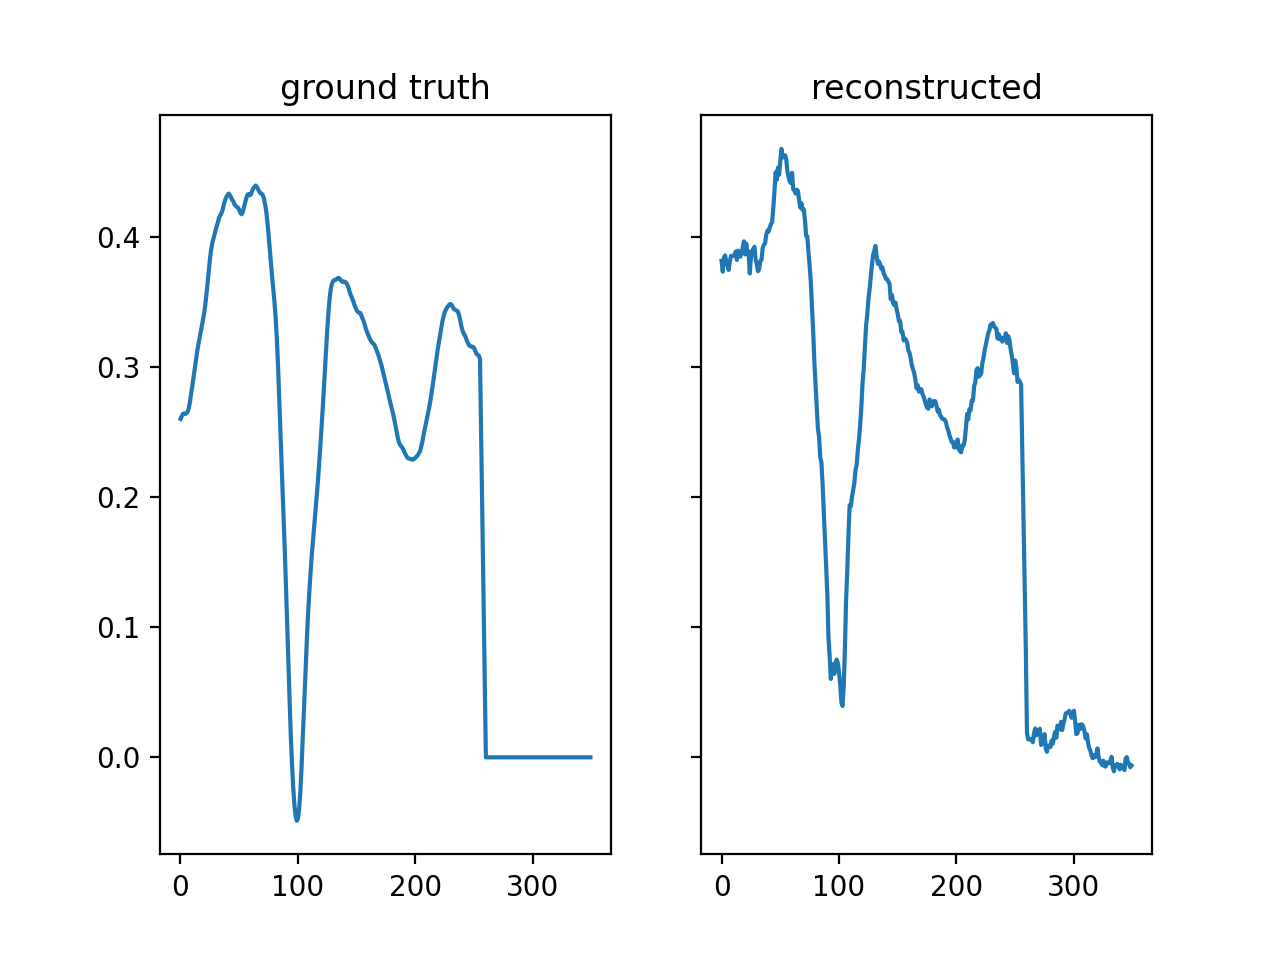

<IPython.core.display.Javascript object>


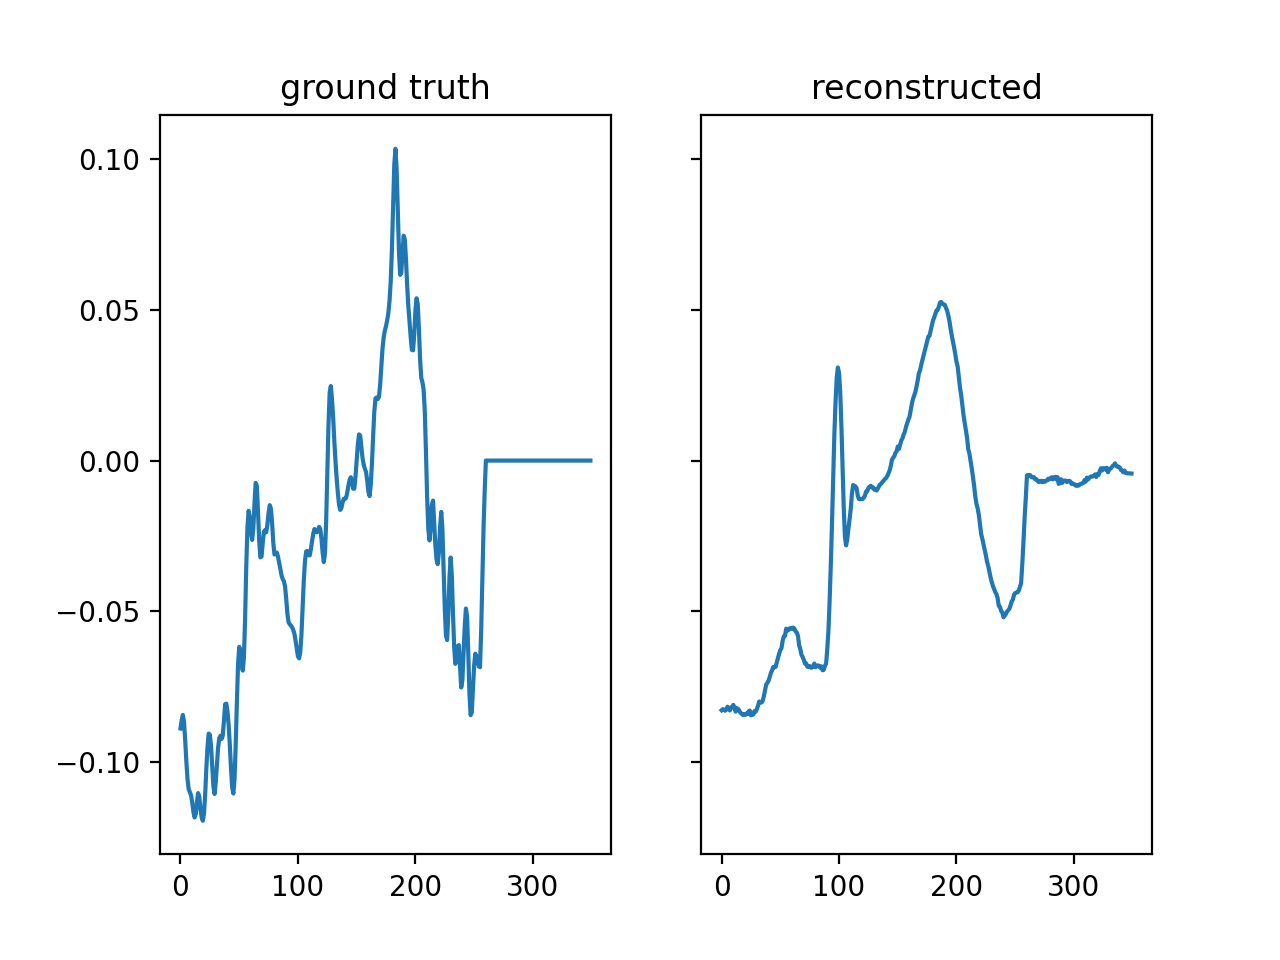

<IPython.core.display.Javascript object>


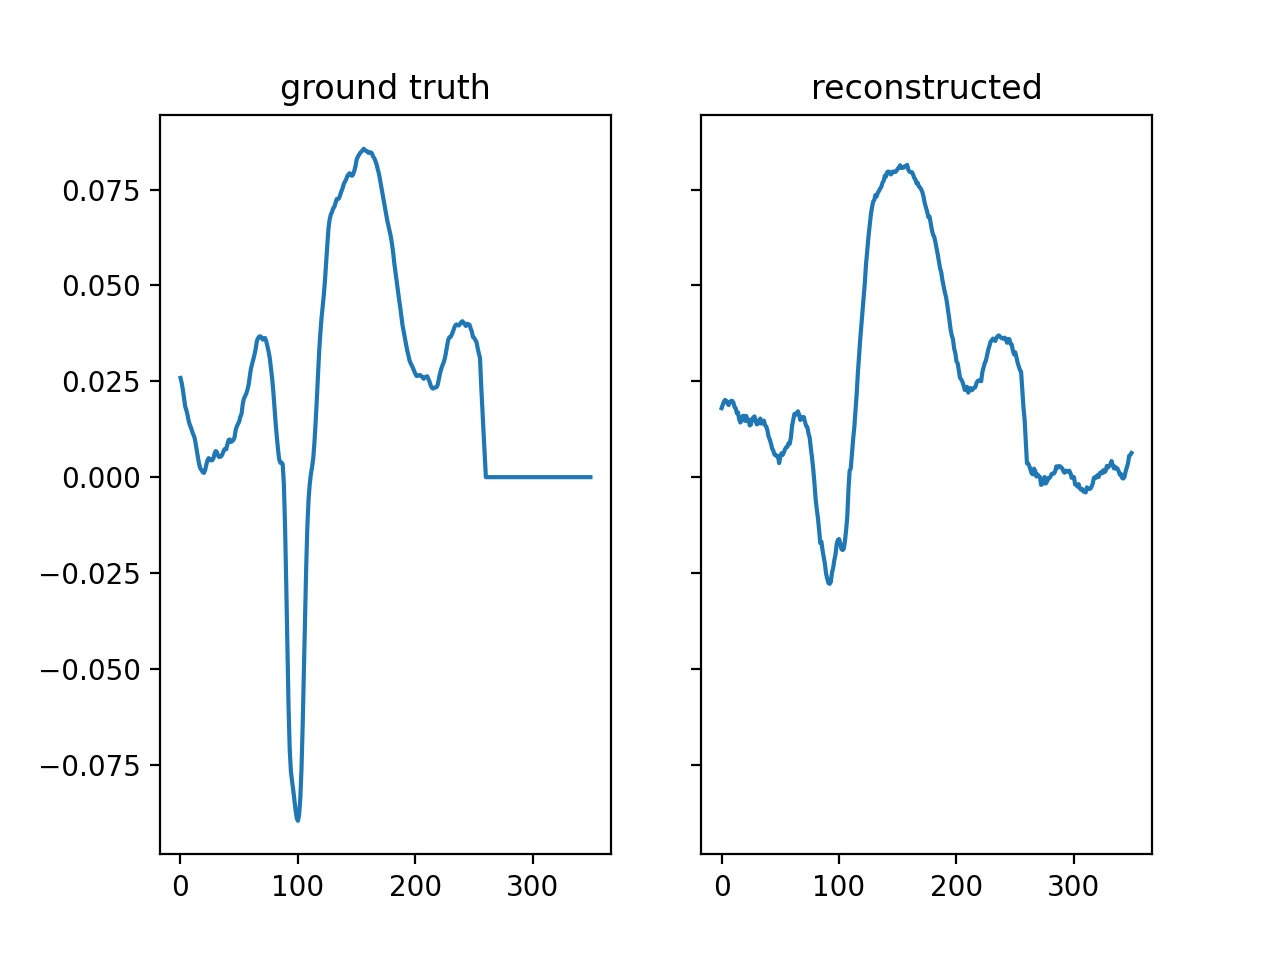

reconstr_errors avg : 3.0594871044158936, thresh : 4.268124580383301


<IPython.core.display.Javascript object>


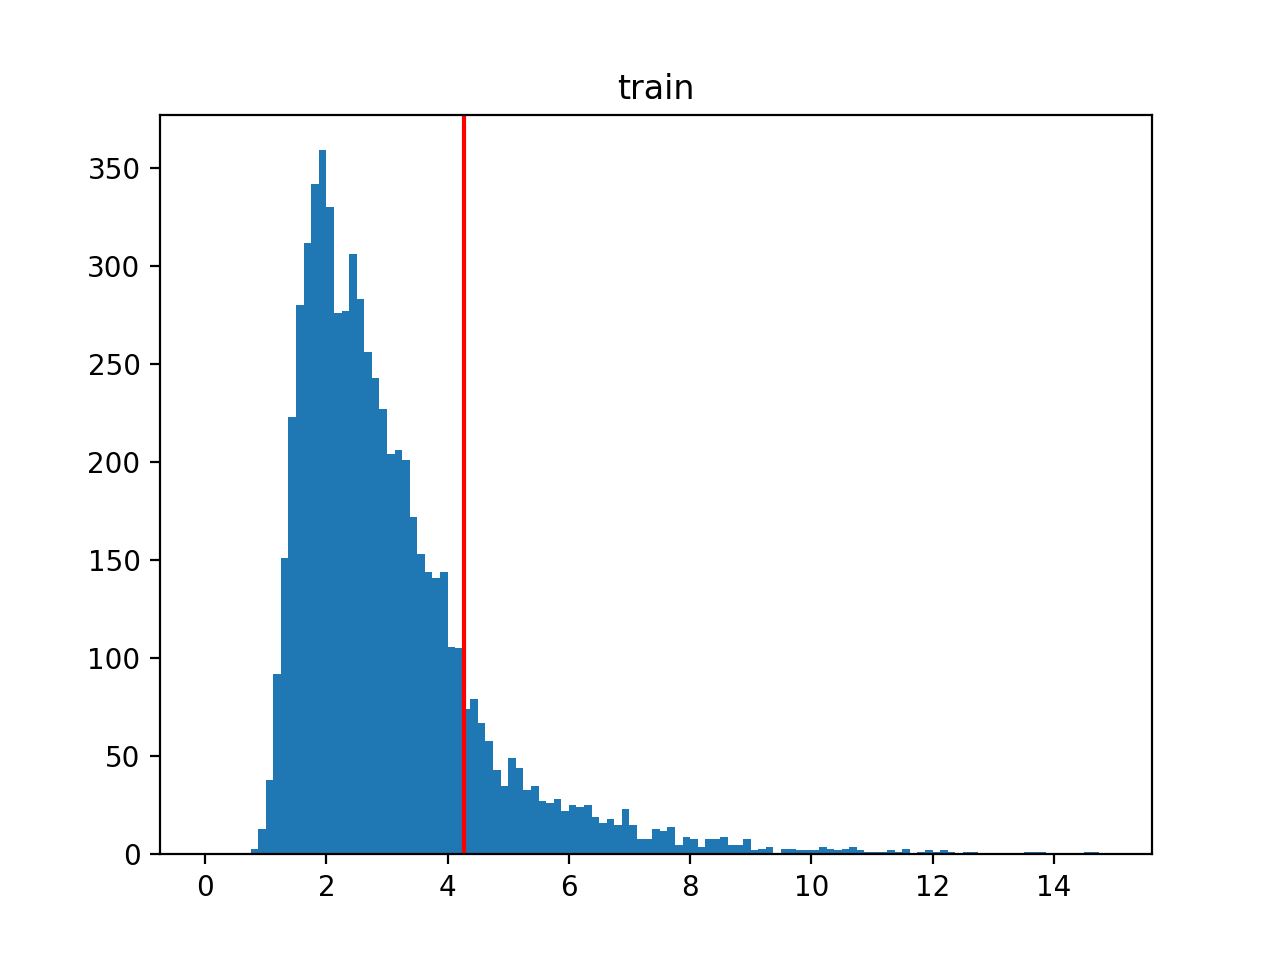

<IPython.core.display.Javascript object>


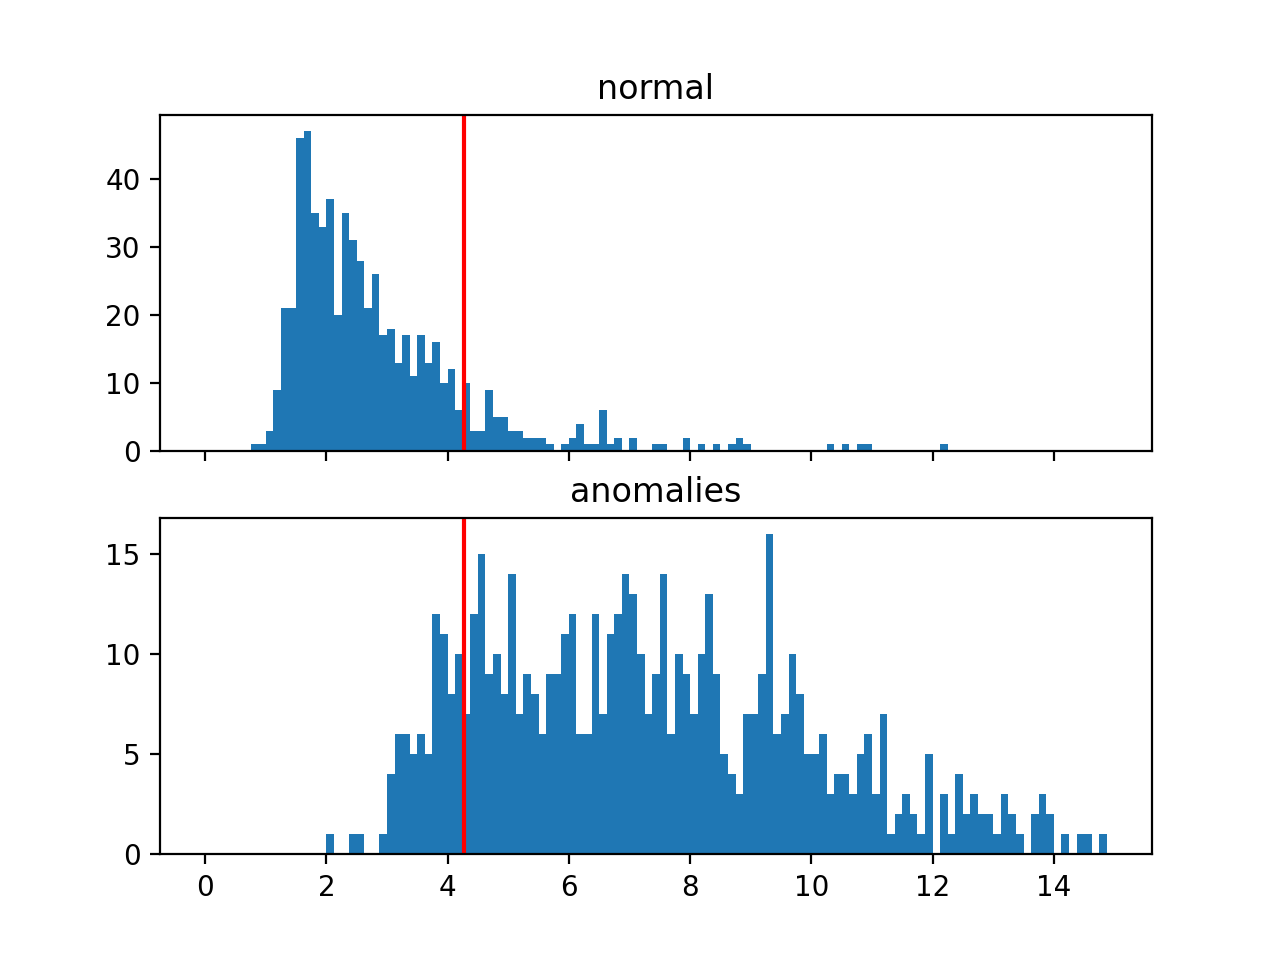

 avg recontruction error 
 	 normal data : 2.9004671573638916, anomalies : 7.944664001464844


<IPython.core.display.Javascript object>


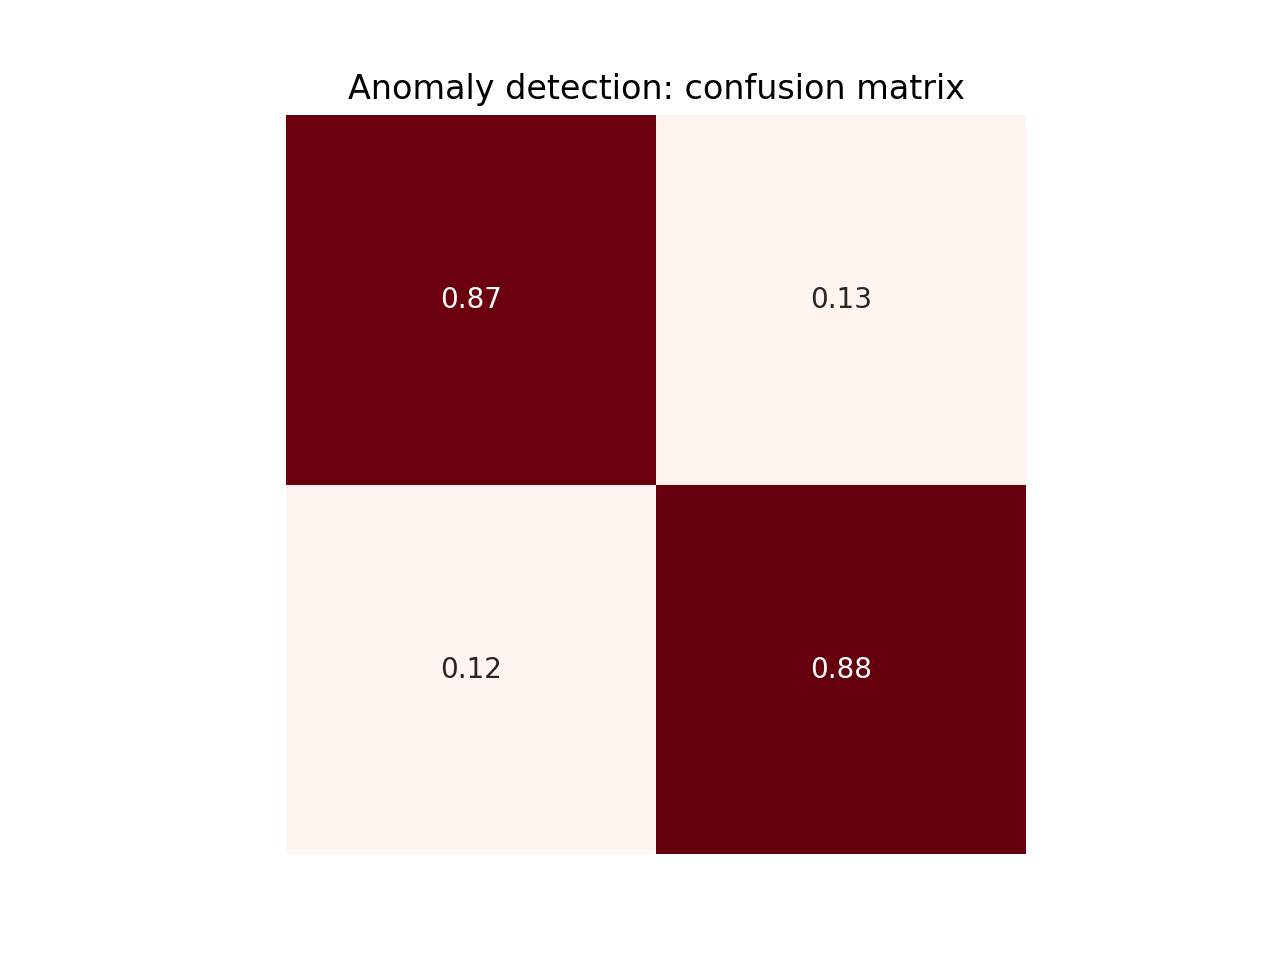

Quality measures of our classifier:
	 precision : 0.8670886158943176
	 recall : 0.876800000667572
	 F1_score : 0.8719173073768616


In [10]:
np.random.seed(66)
torch.manual_seed(66)

train_loader, val_loader, test_loader = get_data()
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

trainer = VAE_Trainer(model = model,
                      train_loader = train_loader, 
                      val_loader = val_loader, 
                      test_loader = test_loader, 
                      optimizer = optimizer)

model = trainer.train(plot=True)
plot_reconstr(model, test_loader)
trainer.test()

A vantage of having a probabilistic representation of the encodings is that we can extract uncertainties over the reconstructed data. In the following cell we will perform a simple Monte Carlo evaluation of the uncertainties and plot confidence intervals around the mean reconstruction of the input.

<IPython.core.display.Javascript object>


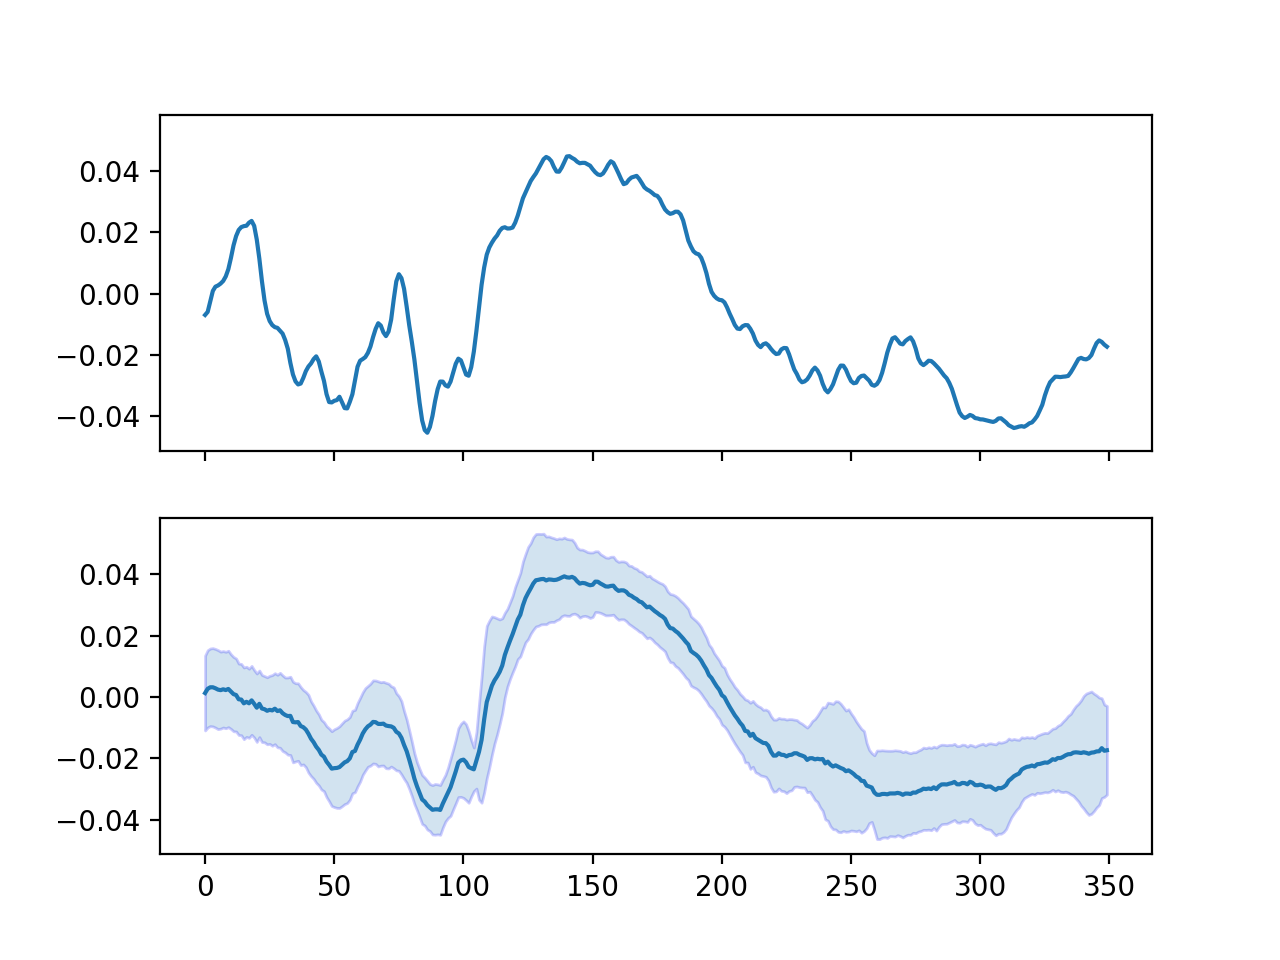

In [11]:
torch.manual_seed(1)
data = next(iter(train_loader))['data'][0]
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
ax[0].plot(np.arange(350), data)

model.eval()
mean, logstd = model.encode(data)
reconstructed_l = []
for i in range(10):
    z = model.reparameterize(mean, logstd)
    reconstructed_l.append(model.decode(z).unsqueeze(0))
reconstructed = torch.cat(reconstructed_l, axis=0)
mean = reconstructed.mean(axis=0).detach().numpy()
std = reconstructed.std(axis=0).detach().numpy()
ax[1].plot(np.arange(350), mean)
ax[1].fill_between(np.arange(350), mean + 2*std, mean - 2*std, alpha=0.2, edgecolor='blue')
fig.show()

VAEs can be used to generate new datapoints. Once the network has been trained, we can sample latent representations from the prior distribution (in our case a standard gaussian) and decode them to produce new unseen data. The same mechanism is at the base of GANs. 

Try to produce new data yourself (the box is not graded).

<IPython.core.display.Javascript object>


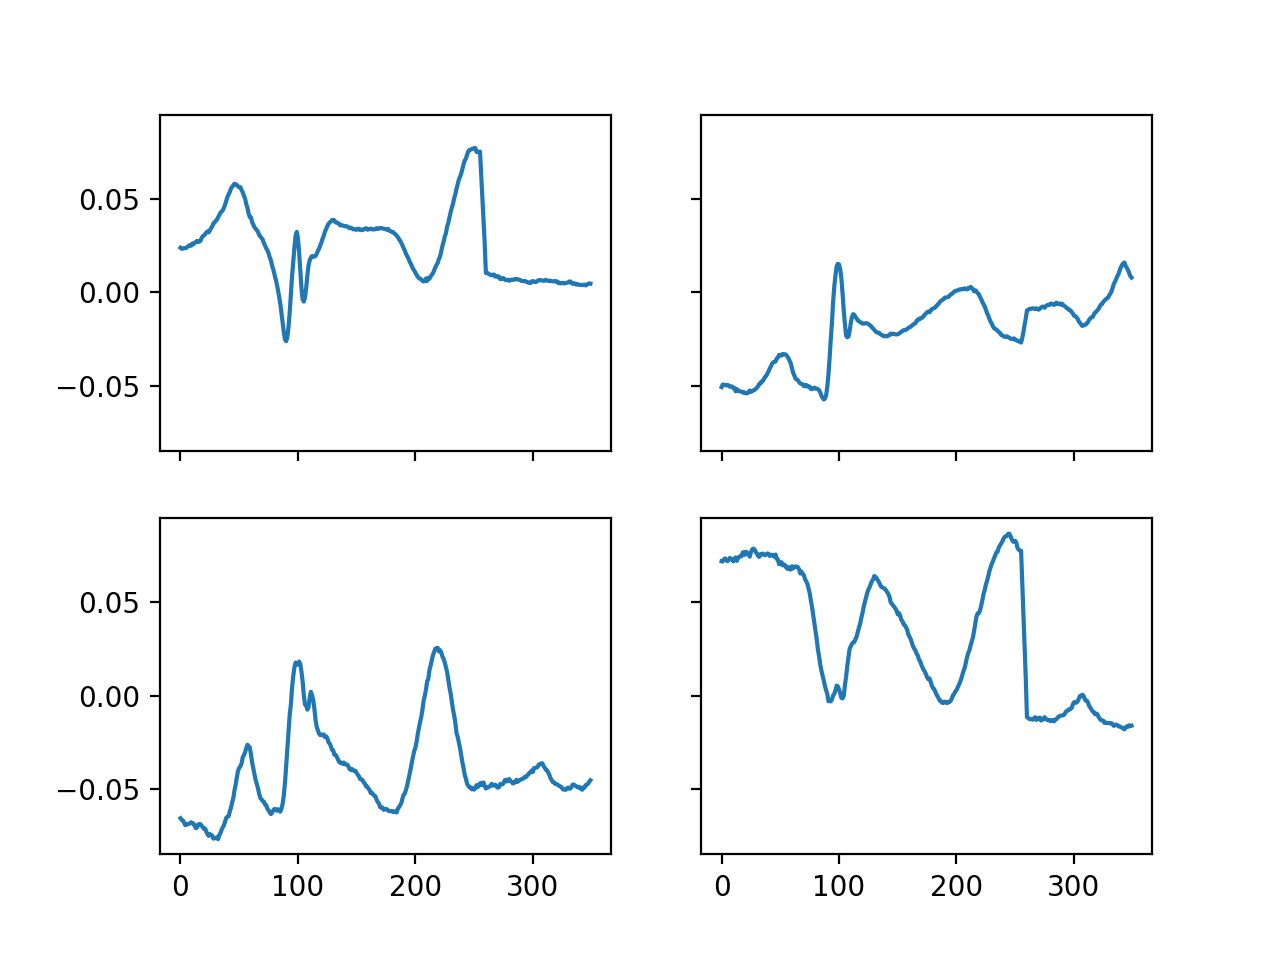

In [12]:
torch.manual_seed(1)
size = model.embedding_dim
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
model.eval()
for i in range(2):
    for j in range(2):
        sample = None           # sample from the prior (standard normal)
        new_data = None         # feed the sample to the decoder to produce new data
        sample = torch.randn(1, size)          # sample from the prior (standard normal)
        new_data = model.decode(sample).squeeze().detach().numpy()        # feed the sample to the decoder to produce new data
        #raise NotImplementedError()
        # if you get an error in the plot function, just have a look at how plots were produced in the block above
        axs[i,j].plot(np.arange(350), new_data)
fig.show()

We have seen the basic structure of a VAE, tested it on a anomaly detection task and seen how new data can be generated by means of the decoder. We will now see how we can enforce simple properties on the representations in the latent space.

By minimizing the KL we are forcing the representations (remember that these are distributions, not single values) produced by the encoder to be as close as possible to a standard normal. We could go beyond this and impose, for example, that the distributions of representations corresponding to different classes of data occupy distinct sub-volumes of the latent space.

Our training set will now consist of ECGs of both 'normal' and 'PVC' classes. We will train, in parallel to a standard VAE (as above), a linear classifier that takes in input the means of the distributions produced by the encoder and outputs if the datapoint is normal or an anomaly. In this way the means of the distributions corresponding to the two different classes will be pushed in linearly separable volumes of the latent space.

Implement a simple classifier of one single fully connected layer. Select the right activation function for a binary classifier (you have already encountered it in a previous exercise).

Hint: torch.nn module has useful functions...

In [13]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = None           # f(ully)c(onnected)
        self.activation = None   # we need a differentiable function with codomain (0,1)... 
        self.fc = nn.Linear(input_dim, 1)
        self.activation = nn.Sigmoid()
        #raise NotImplementedError()
        
    def forward(self, data):
        return self.activation(self.fc(data))
    
    
class Composed(nn.Module):
    def __init__(self, input_dim : int = 350, embedding_dim : int = 3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.vae = VAE(input_dim, embedding_dim)
        self.classifier = BinaryClassifier(embedding_dim)
    def forward(self, data):
        out, mean, logstd, z = self.vae(data)
        logits = self.classifier(mean).squeeze()
        return [out, mean, logstd, z, logits]

In [14]:
# Binary_classifier - 2 point

# hidden tests checking if layers are correct

Try to implement the loss of our new architecture. It will have to be composed by 3 additive terms: the likelihood for the reconstruction, the (scaled!) kl divergence for the prior and a term for the binary classifier. 

(For this task you may drop the KL warmup factor)

Hints: 
1. take a look at the VAE_Trainer loss function implemented above
2. check ComposedTrainer's new attribute: class_loss 
3. remember that we already implemented a function for the KL divergence 

In [22]:
class ComposedVAE_Trainer(AbstractTrainer):
    def __init__(self, model : nn.Module, 
                 train_loader : Optional[DataLoader] = None, 
                 val_loader : Optional[DataLoader] = None,
                 test_loader : Optional[DataLoader] = None, 
                 optimizer = None):
        super().__init__(model=model,
                         train_loader = train_loader,
                         val_loader = val_loader,
                         test_loader = test_loader,
                         optimizer = optimizer,
                         early_stop = 3)
        self.class_loss = nn.BCELoss(reduction='sum')     ## for the reconstr_loss we set reduction='none'
                                                          ## because of how I used it in the test function. 
                                                          ## In general it is easier to use reductions directly as
                                                          ## in this case. Check what this reduction='sum' does.
        self.measures = {'loss' : [], 'reconstr' : [], 'kl' : [], 'classif' : []}

    def _loss(self, target, label, *args):
        out = args[0] 
        mean = args[1]
        logstd = args[2]
        logits = args[4]
        batch_dim = target.shape[0]
        #                               <============================ THE FOLLOWING 4 LINES ONLY
        reconstr_error = None      # an old friend
        kl = None                  # another old friend
        classif_error = None       # a new one
        loss = None                
        
        reconstr_error = torch.nn.functional.binary_cross_entropy(torch.sigmoid(out), target, reduction='none').sum()      # an old friend.
        kl = KL_normnorm(mean, logstd).sum()
        classif_error = self.class_loss(logits, label)
        loss = reconstr_error + kl + classif_error
        #raise NotImplementedError()
        return [loss, reconstr_error, kl, classif_error]

    def test(self):
        self.model.eval()
        means = []
        labels = []
        preds = []
        with torch.no_grad():
            for batch in self.val_loader:
                data = batch['data'].to(self.device)
                label = batch['labels'].to(self.device).squeeze()
                out, mean, logstd, z, logits = self.model(data)
                means.append(mean)
                labels.append(label)
                preds.append((logits>0.5).float())
        labels = torch.cat(labels).numpy().astype('int')
        preds = torch.cat(preds).numpy().astype('int')
        
        fig, ax = plt.subplots()
        cm = confusion_matrix(labels, preds, normalize='true')
        sb.heatmap(cm, square=True, xticklabels=False, yticklabels=False, 
                    annot=True, cbar=False, cmap="Reds", fmt='.2f').get_figure()
        ax.set_title('Classification: confusion matrix')
        fig.show()


        means = torch.cat(means).numpy()
        colors={0: 'blue', 1:'red'}
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.scatter(means[:,0], means[:,1], means[:,2], marker=".", s=20, c=[colors[i] for i in labels])
        ax.set_title('Latent space')
        ax.set_xlim(-4., 4.)
        ax.set_ylim(-4., 4.)
        ax.set_zlim(-4., 4.)
        fig.show()


In [23]:
# Composed_Loss - 1 point

# hidden tests

We will now train our network for a cycle of 100 epochs, using as early stopping criteria the classification error on the validation set, with a scaling constant of 0.5 for the KL divergence and using (or not) KL warmup. 

Graphs produced are:
1. summary of training
2. confusion matrix associated to the binary classifier
4. interactive 3D graph in the latent space of the means of the representation distributions produced by the encoder on the validation set, where blue points are 'normal' and red points are 'PVC' ECGs.

In [24]:
np.random.seed(666)
torch.manual_seed(666)

train_loader, val_loader, test_loader = get_data(composed=True)
model = Composed()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

trainer = ComposedVAE_Trainer(model = model,
                          train_loader = train_loader, 
                          val_loader = val_loader, 
                          test_loader = test_loader, 
                          optimizer = optimizer)

model = trainer.train(plot=True)
plot_reconstr(model, test_loader)
trainer.test()


===> epoch: 0
Train	loss : -7341.834237 reconstr : -9780.464209 kl : 2345.049211 classif : 93.580825 
Val	loss : -24749.420359 reconstr : -26163.776591 kl : 1326.239647 classif : 88.116536 
Model saved

===> epoch: 1
Train	loss : -25876.812969 reconstr : -27173.158395 kl : 1205.164696 classif : 91.180676 
Val	loss : -28422.316284 reconstr : -29545.409729 kl : 1037.38283 classif : 85.710801 
Model saved

===> epoch: 2
Train	loss : -28608.392166 reconstr : -29778.24461 kl : 1080.836133 classif : 89.016391 
Val	loss : -31720.137309 reconstr : -32833.316711 kl : 1030.187026 classif : 82.992733 
Model saved

===> epoch: 3
Train	loss : -31526.327512 reconstr : -32665.794673 kl : 1053.419913 classif : 86.047124 
Val	loss : -32825.624003 reconstr : -33886.434204 kl : 979.15259 classif : 81.657605 
Model saved

===> epoch: 4
Train	loss : -33012.599073 reconstr : -34091.097197 kl : 993.346753 classif : 85.151191 
Val	loss : -36305.958659 reconstr : -37339.552531 kl : 953.016759 classif : 80.576

/auto-grading/assignments/Utils.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=len(measures), ncols=1, sharex=True, figsize=(5, 7))


<IPython.core.display.Javascript object>

Let's plot some reconstructed data: 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We will finally produce two ECGs corresponding to the two different classes 'normal' and 'PVC'.

/tmp/ipykernel_55/771126551.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)


<IPython.core.display.Javascript object>


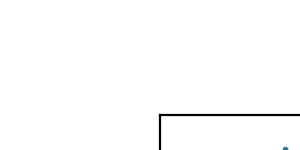

In [18]:
torch.manual_seed(1)
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
embs = torch.tensor([[0., 0., -3.], [0., 0., 3.]])
classes = {0:'normal', 1:'PVC'}
model.eval()
for i in range(2):
        new_data = model.vae.decode(embs[i]).detach().numpy()
        axs[i].plot(np.arange(350), new_data)
        c = int(model.classifier(embs[i]).detach().numpy()>0.5)
        axs[i].set_title(classes[c])
fig.show()